In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
X = []
Y = []

for i in tqdm(glob('data/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('data/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)    




100%|██████████| 2000/2000 [00:00<00:00, 3594.48it/s]


In [20]:
X = np.array(X)
X = X/255.0
Y = np.array(Y)

In [21]:
X = np.expand_dims(X,-1)

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

model = tf.keras.models.Sequential([
      Input(shape=(64, 64, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 1, activation = 'sigmoid')
  ])

In [24]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='eye_detector.keras',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)
model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9064 - loss: 0.1990
Epoch 1: val_loss improved from inf to 0.83519, saving model to bestModel.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9072 - loss: 0.1975 - val_accuracy: 0.5187 - val_loss: 0.8352
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9845 - loss: 0.0484
Epoch 2: val_loss did not improve from 0.83519
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9845 - loss: 0.0483 - val_accuracy: 0.5187 - val_loss: 2.4485
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9942 - loss: 0.0217
Epoch 3: val_loss improved from 0.83519 to 0.61268, saving model to bestModel.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9941 - loss: 0.0219 - val_accuracy: 0.6306 - val_loss: 0.6127
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9952 - loss: 0.0151
Epoch 4: val_loss did not improve from 0.61268
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.

In [26]:
model.evaluate(x_test, y_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9990 - loss: 0.0031


[0.0067820316180586815, 0.9977272748947144]

In [ ]:
from keras.models import load_model
best_model = load_model('eye_detector.keras')
best_model.evaluate(x_test, y_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9990 - loss: 0.0031


[0.0067820316180586815, 0.9977272748947144]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


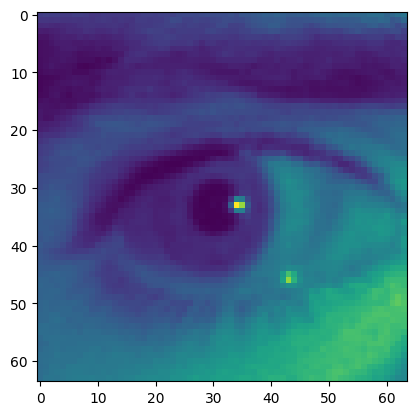

Open
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


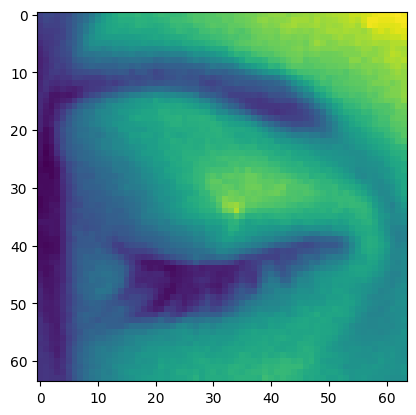

Closed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


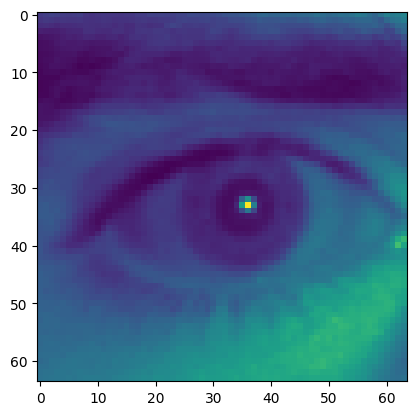

Open
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


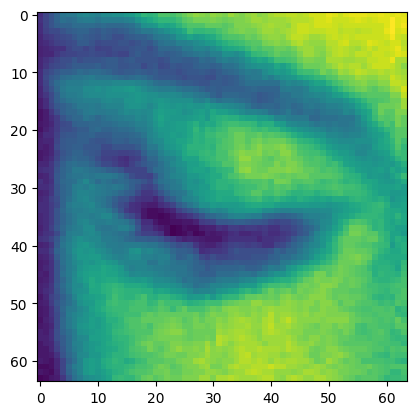

Closed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


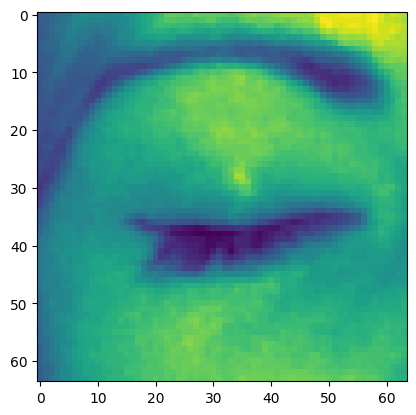

Closed


In [28]:
for i in x_test[0:5]:
    result = best_model.predict(np.expand_dims(i,0))
    plt.imshow(i)
    plt.show()
    
    if result > 0.5:
        print('Open')
    else:
        print("Closed")
    

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Text(0.5, 25.722222222222214, 'Actual')

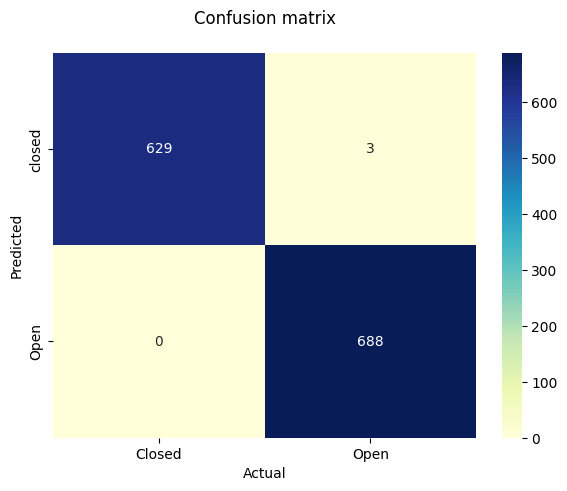

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")